In [1]:
import copy
import csv
import pandas as pd
import numpy as np
import scipy as scipy
from scipy.stats import pearsonr
import math
import matplotlib
import matplotlib.pyplot as plt
#from matplotlib_venn import venn3, venn3_circles, venn2, venn2_circles
import itertools
from copy import deepcopy
from collections import defaultdict
from datetime import datetime
import random
pd.options.display.mpl_style = 'default'
%matplotlib inline
import pickle
#%pylab inline
import os
import matplotlib.ticker as mtick
from scipy.stats import chi2_contingency
import re

/home/oryoruk/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2881: FutureWarning: 
mpl_style had been deprecated and will be removed in a future version.
Use `matplotlib.pyplot.style.use` instead.

  exec(code_obj, self.user_global_ns, self.user_ns)


### 1. write code to read substitution rate dictionary pickles into dataframes

do these things:

1. write code to read substitution rate dictionary pickles into dataframes
2. save rates (ref_count & sub_count for each context) into csv files for individual chromosomes
3. collate all 7mer rates into genomewide rates and save into csv
4. compare genome wide rates (with or without X chromosome?) to Varun's rates
5. collate 7mer rates into 3mer rates for each chromosome and save
6. collate all 3mer rates into genomewide rates and save into csv

In [100]:
!ls ./../../output/nc_7mer_sub_rates_per_chrom_1kgp3/

1   11	13  15	17  19	20  22	4  6  8  X
10  12	14  16	18  2	21  3	5  7  9


In [101]:
output_folder = './../../output/nc_7mer_sub_rates_per_chrom_1kgp3/'

In [102]:
def df_to_dct(df):
    dct = {}
    for i, row in df.iterrows():
        dct[row.ref+row.alt] = [row.ref_count,row.sub_count]
    return dct

def dct_to_df(dct):
    sub_rates_cols = ['ref','alt','ref_count','sub_count']
    df = pd.DataFrame(columns = sub_rates_cols)
    context_length = len(dct.keys()[0])/2
    for key in dct:
        df = df.append(pd.DataFrame([[key[:context_length],key[context_length:],dct[key][0],dct[key][1]]],columns=sub_rates_cols),ignore_index=True)  
    return df

In [104]:
chrom = '22'

In [105]:
with open(output_folder + chrom) as fileObject:
    sub_rates_dct_chr22 = pickle.load(fileObject)
sub_rates_chr22 = dct_to_df(sub_rates_dct_chr22)

In [106]:
sub_rates_chr22.head()

,ref,alt,ref_count,sub_count
0,CGACCGG,CGAACGG,51,0
1,GTGAGCG,GTGTGCG,428,0
2,TCAAAGA,TCACAGA,2026,2
3,ACCCCGT,ACCACGT,1674,6
4,CGACCTT,CGAGCTT,222,0


In [107]:
sub_rates_chr22.tail()

,ref,alt,ref_count,sub_count
24571,TCCATAG,TCCGTAG,842,22
24572,AATCTAG,AATATAG,786,3
24573,CGCAGGG,CGCTGGG,668,0
24574,GAGCTAC,GAGGTAC,766,3
24575,ACGCACA,ACGTACA,546,4


In [108]:
sub_rates_chr22.describe()

,ref,alt,ref_count,sub_count
count,24576,24576,24576,24576
unique,8192,16384,3014,155
top,TGCACGG,GGAGACG,148,0
freq,3,2,51,4040


In [109]:
len(sub_rates_chr22)

24576

### 2. save rates (ref_count & sub_count for each context) into csv files for individual chromosomes

In [112]:
for chrom in ["1","2","3","4","5","6","7","8","9","10","11","12","13","14","15","16","17","18","19","20","21","22","X"]:
    with open(output_folder + chrom) as fileObject:
        sub_rates_dct_chrom = pickle.load(fileObject)
    sub_rates_chrom = dct_to_df(sub_rates_dct_chrom)
    sub_rates_chrom.to_csv(output_folder+'chr'+chrom+'_7mer_counts.csv',sep='\t',index=False,header=False)
    print 'chrom ', chrom, ' is saved'

chrom  1  is saved
chrom  2  is saved
chrom  3  is saved
chrom  4  is saved
chrom  5  is saved
chrom  6  is saved
chrom  7  is saved
chrom  8  is saved
chrom  9  is saved
chrom  10  is saved
chrom  11  is saved
chrom  12  is saved
chrom  13  is saved
chrom  14  is saved
chrom  15  is saved
chrom  16  is saved
chrom  17  is saved
chrom  18  is saved
chrom  19  is saved
chrom  20  is saved
chrom  21  is saved
chrom  22  is saved
chrom  X  is saved


### 3. collate all 7mer rates into genomewide rates and save into csv#

In [113]:
#initialize counts
sub_rates_dct = {}
#here are the substitutions and corresponding fold I am recording:
subs   = ['CT','CA','CG','AT','AC','AG']
#folds = ['GA','GT','GC','TA','TG','TC']
nucs = list('GATC')
for sub in subs:
    for flanks in itertools.product(nucs,repeat = 6):
        ref = ''.join(flanks[:3]) + sub[0] + ''.join(flanks[3:])
        alt = ''.join(flanks[:3]) + sub[1] + ''.join(flanks[3:])
        sub_rates_dct[ref+alt] = [0,0]

In [114]:
output_folder

'./../../output/nc_7mer_sub_rates_per_chrom_1kgp3/'

In [115]:
for chrom in ["1","2","3","4","5","6","7","8","9","10","11","12","13","14","15","16","17","18","19","20","21","22"]:
    with open(output_folder + chrom) as fileObject:
            sub_rates_dct_chrom = pickle.load(fileObject)
        for key in sub_rates_dct_chrom:
            sub_rates_dct[key][0] += sub_rates_dct_chrom[key][0]
            sub_rates_dct[key][1] += sub_rates_dct_chrom[key][1]
sub_rates = dct_to_df(sub_rates_dct)
sub_rates.to_csv(output_folder+'whole_autosome_7mer_counts.csv',sep='\t',index=False,header=False)

In [116]:
for chrom in ['X']:
    with open(output_folder + chrom) as fileObject:
        sub_rates_dct_chrom = pickle.load(fileObject)
        for key in sub_rates_dct_chrom:
            sub_rates_dct[key][0] += sub_rates_dct_chrom[key][0]
            sub_rates_dct[key][1] += sub_rates_dct_chrom[key][1]
sub_rates = dct_to_df(sub_rates_dct)
sub_rates.to_csv(output_folder+'whole_genome_7mer_counts.csv',sep='\t',index=False,header=False)

### 4. compare genome wide rates (with or without X chromosome?) to Varun's rates

In [187]:
sub_rates_autosomal = pd.read_csv('./../../output/nc_7mer_sub_rates_per_chrom_1kgp3/whole_autosome_7mer_counts.csv',sep='\t',header=None,names=['ref','alt','ref_count','sub_count'])

In [188]:
sub_rates_autosomal

,ref,alt,ref_count,sub_count
0,CGACCGG,CGAACGG,2343,15
1,GTGAGCG,GTGTGCG,22189,24
2,TCAAAGA,TCACAGA,308436,403
3,TCGAAGC,TCGGAGC,12259,28
4,CGACCTT,CGAGCTT,16542,44
5,GTGATGG,GTGCTGG,171521,193
6,CGACGTC,CGAGGTC,2889,32
7,AGCCTCG,AGCTTCG,41089,390
8,TGAAAAA,TGAGAAA,606576,2863
9,AGCCCAT,AGCTCAT,129301,1090


In [189]:
sub_rates_autosomal['rates'] = sub_rates_autosomal.sub_count / sub_rates_autosomal.ref_count

In [190]:
sub_rates_autosomal.rates = sub_rates_autosomal.rates.astype(float)

In [192]:
sub_rates_autosomal.rates.describe()

count    24576.000000
mean         0.010059
std          0.026969
min          0.000000
25%          0.001859
50%          0.003383
75%          0.007167
max          0.244166
Name: rates, dtype: float64

In [193]:
!ls ./../../data/aggarwala_voight_2016/

ng.3511-S2.xlsx


In [166]:
agg_sub_rates = pd.read_excel('./../../data/aggarwala_voight_2016/ng.3511-S2.xlsx', sheetname='Supplementary Table 7', header=0)

In [167]:
agg_sub_rates.head()

,Reference-sequences,Alternative-sequence,African autosomal substitution probability from reference to alternative,Asian autosomal substitution probability from reference to alternative,European autosomal substitution probability from reference to alternative,Reverse complement reference,Reverse complement alternative
0,TCTATAC,TCTTTAC,0.001088,0.000626,0.000693,GTATAGA,GTAAAGA
1,GAGCTTA,GAGGTTA,0.001690,0.001138,0.001092,TAAGCTC,TAACCTC
2,CAACAAG,CAAAAAG,0.004224,0.002177,0.002568,CTTGTTG,CTTTTTG
3,TGTATGA,TGTTTGA,0.001655,0.000888,0.000919,TCATACA,TCAAACA
4,TTAACCA,TTACCCA,0.000990,0.000647,0.000784,TGGTTAA,TGGGTAA


In [170]:
agg_sub_rates['African autosomal substitution probability from reference to alternative'].describe()

count    24576.000000
mean         0.006555
std          0.017500
min          0.000165
25%          0.001192
50%          0.002160
75%          0.004828
max          0.162509
Name: African autosomal substitution probability from reference to alternative, dtype: float64

In [194]:
agg_sub_rates.drop('Asian autosomal substitution probability from reference to alternative',axis=1,inplace=True)

In [195]:
agg_sub_rates.drop('European autosomal substitution probability from reference to alternative',axis=1,inplace=True)

In [196]:
agg_sub_rates.drop('Reverse complement reference',axis=1,inplace=True)

In [197]:
agg_sub_rates.drop('Reverse complement alternative',axis=1,inplace=True)

In [198]:
agg_sub_rates.rename(columns={'Reference-sequences':'ref','Alternative-sequence':'alt','African autosomal substitution probability from reference to alternative':'rates'}, inplace=True)

In [199]:
agg_sub_rates.head()

,ref,alt,rates
0,TCTATAC,TCTTTAC,0.001088
1,GAGCTTA,GAGGTTA,0.001690
2,CAACAAG,CAAAAAG,0.004224
3,TGTATGA,TGTTTGA,0.001655
4,TTAACCA,TTACCCA,0.000990


In [204]:
for key in sub_rates_7mer_dct_chrom.keys():
    alt, ref = key[:7], key[7:]
    

24576

In [206]:
sub_rates_autosomal[sub_rates_autosomal.alt=='TCTTTAC']

,ref,alt,ref_count,sub_count,rates
11576,TCTATAC,TCTTTAC,103802,169,0.001628
14941,TCTCTAC,TCTTTAC,371751,2504,0.006736


In [207]:
sub_rates_autosomal[sub_rates_autosomal.ref=='TCTGTAC']

,ref,alt,ref_count,sub_count,rates


In [210]:
sub_rates_autosomal[sub_rates_autosomal.ref=='AAACAAA'].rates

,ref,alt,ref_count,sub_count,rates
1246,AAACAAA,AAAGAAA,997981,3995,0.004003
1555,AAACAAA,AAATAAA,997981,7590,0.007605
14790,AAACAAA,AAAAAAA,997981,11674,0.011698


In [208]:
len(sub_rates_autosomal)

24576

In [215]:
sub_rates_autosomal[(sub_rates_autosomal.ref == 'AAACAAA')&(sub_rates_autosomal.alt == 'AAAGAAA')].rates.iloc[0]

0.004003082223008254

In [217]:
my_cpg_ct_rates = []
varuns_cpg_ct_rates = []
for key in sub_rates_7mer_dct_chrom.keys():
    ref, alt = key[:7], key[7:]
    my_cpg_ct_rates.append(sub_rates_autosomal[(sub_rates_autosomal.ref == ref)&(sub_rates_autosomal.alt == alt)].rates.iloc[0])
    varuns_cpg_ct_rates.append(agg_sub_rates[(agg_sub_rates.ref == ref)&(agg_sub_rates.alt == alt)].rates.iloc[0])

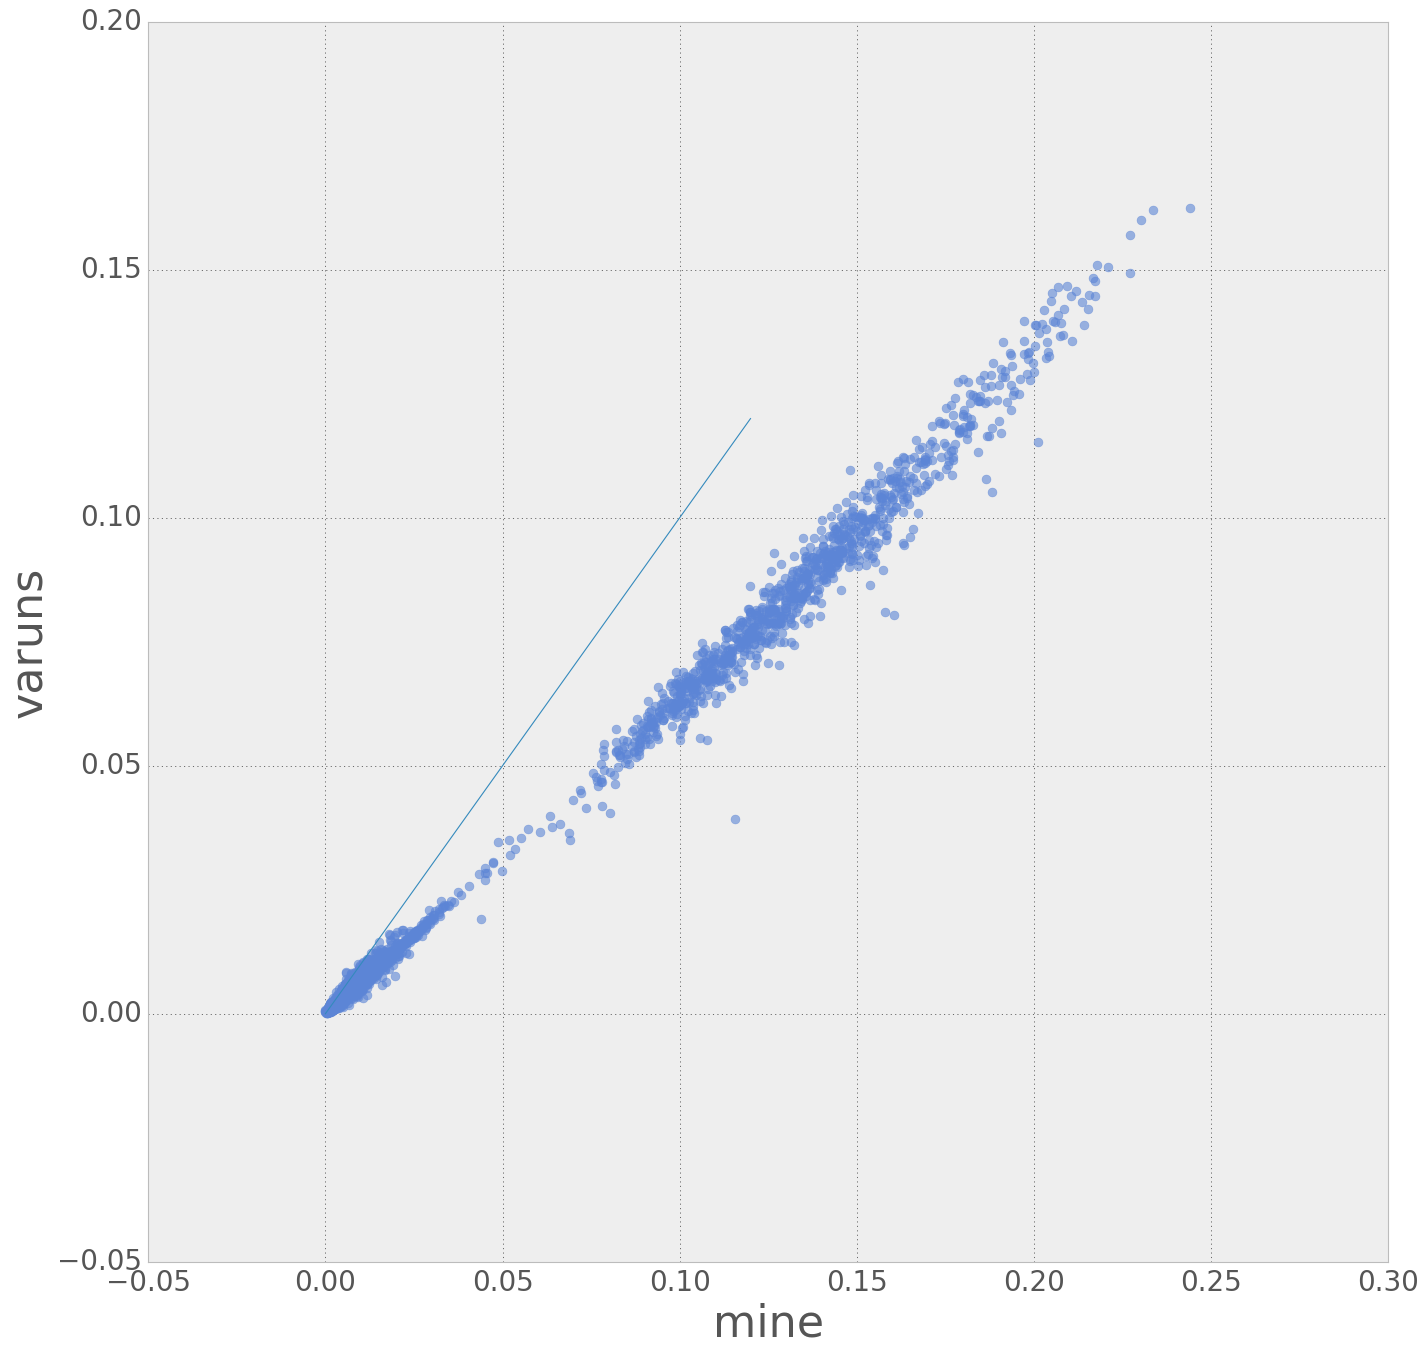

In [223]:
plt.rcParams['figure.figsize'] = 20, 20
plt.rcParams['savefig.dpi'] = 50
s = [4*2**4]
colors = ['#5C85D6','#cf5f75']
#s1_dots = 
plt.scatter(my_cpg_ct_rates,varuns_cpg_ct_rates, s=s, color = colors[0], alpha = 0.6)
plt.plot([0.0,0.12],[0.0,0.12])
#plt.xlim([0,0.12])
#plt.ylim([0,0.12])

plt.xlabel('mine', fontsize=40)
plt.ylabel('varuns', fontsize=40)
plt.tick_params(axis='x', labelsize=25)
plt.tick_params(axis='y', labelsize=25)
#s4_dots = plt.scatter(subs_s4,counts_s4, s=s, color = colors[1], alpha = 1)
#plt.legend((s1_dots,s4_dots),("S1","S4"), scatterpoints=1,fontsize=20)
plt.show()

In [218]:
scipy.stats.pearsonr(varuns_cpg_ct_rates,my_cpg_ct_rates)

(0.99838506913915392, 0.0)

### looks god to me!

### 5. collate 7mer rates into 3mer rates for each chromosome and save

In [123]:
def empty_sub_rates_3mer_dct():
    #initialize counts
    sub_rates_3mer_dct = {}
    #here are the substitutions and corresponding fold I am recording:
    subs   = ['CT','CA','CG','AT','AC','AG']
    #folds = ['GA','GT','GC','TA','TG','TC']
    nucs = list('GATC')
    for sub in subs:
        for flanks in itertools.product(nucs,repeat = 2):
            ref = ''.join(flanks[:1]) + sub[0] + ''.join(flanks[1:])
            alt = ''.join(flanks[:1]) + sub[1] + ''.join(flanks[1:])
            sub_rates_3mer_dct[ref+alt] = [0,0]
    return sub_rates_3mer_dct

will do 5 and 6 together below

### 6. collate all 3mer rates into genomewide rates and save into csv

In [126]:
sub_rates_3mer_dct = empty_sub_rates_3mer_dct()
for chrom in ["1","2","3","4","5","6","7","8","9","10","11","12","13","14","15","16","17","18","19","20","21","22"]:
    with open(output_folder + chrom) as fileObject:
        sub_rates_7mer_dct_chrom = pickle.load(fileObject)
        sub_rates_3mer_dct_chrom = empty_sub_rates_3mer_dct()
        for key in sub_rates_7mer_dct_chrom:
            alt = key[2:5]
            ref = key[9:12]
            sub_rates_3mer_dct_chrom[alt+ref][0]+=sub_rates_7mer_dct_chrom[key][0]
            sub_rates_3mer_dct_chrom[alt+ref][1]+=sub_rates_7mer_dct_chrom[key][1]        
        for key in sub_rates_3mer_dct_chrom:
            sub_rates_3mer_dct[key][0] += sub_rates_3mer_dct_chrom[key][0]
            sub_rates_3mer_dct[key][1] += sub_rates_3mer_dct_chrom[key][1]
    sub_rates_3mer_chrom = dct_to_df(sub_rates_3mer_dct_chrom)
    sub_rates_3mer_chrom.to_csv(output_folder+'chr'+chrom+'_3mer_counts.csv',sep='\t',index=False,header=False)
    print 'chrom ', chrom, ' is saved'     
sub_rates_3mer = dct_to_df(sub_rates_3mer_dct)
sub_rates_3mer.to_csv(output_folder+'whole_autosome_3mer_counts.csv',sep='\t',index=False,header=False)
print 'autosome counts saved'
for chrom in ['X']:
    with open(output_folder + chrom) as fileObject:
        sub_rates_7mer_dct_chrom = pickle.load(fileObject)
        sub_rates_3mer_dct_chrom = empty_sub_rates_3mer_dct()
        for key in sub_rates_7mer_dct_chrom:
            alt = key[2:5]
            ref = key[9:12]
            sub_rates_3mer_dct_chrom[alt+ref][0]+=sub_rates_7mer_dct_chrom[key][0]
            sub_rates_3mer_dct_chrom[alt+ref][1]+=sub_rates_7mer_dct_chrom[key][1]        
        for key in sub_rates_3mer_dct_chrom:
            sub_rates_3mer_dct[key][0] += sub_rates_3mer_dct_chrom[key][0]
            sub_rates_3mer_dct[key][1] += sub_rates_3mer_dct_chrom[key][1]
    sub_rates_3mer_chrom = dct_to_df(sub_rates_3mer_dct_chrom)
    sub_rates_3mer_chrom.to_csv(output_folder+'chr'+chrom+'_3mer_counts.csv',sep='\t',index=False,header=False)
    print 'chrom ', chrom, ' is saved'     
sub_rates_3mer = dct_to_df(sub_rates_3mer_dct)
sub_rates_3mer.to_csv(output_folder+'whole_genome_3mer_counts.csv',sep='\t',index=False,header=False)
print 'genome counts saved'

chrom  1  is saved
chrom  2  is saved
chrom  3  is saved
chrom  4  is saved
chrom  5  is saved
chrom  6  is saved
chrom  7  is saved
chrom  8  is saved
chrom  9  is saved
chrom  10  is saved
chrom  11  is saved
chrom  12  is saved
chrom  13  is saved
chrom  14  is saved
chrom  15  is saved
chrom  16  is saved
chrom  17  is saved
chrom  18  is saved
chrom  19  is saved
chrom  20  is saved
chrom  21  is saved
chrom  22  is saved
autosome counts saved
chrom  X  is saved
genome counts saved


In [125]:
len(sub_rates)

24576

In [127]:
len(sub_rates_3mer)

96

In [129]:
sum(sub_rates.ref_count)

3600087834

In [132]:
sum(sub_rates.sub_count)

17863012

In [134]:
sum(sub_rates_3mer.ref_count)

3600087834

In [135]:
sum(sub_rates_3mer.sub_count)

17863012